In [26]:
#Imports
import pandas as pd
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch, Pitch
from matplotlib.colors import to_rgba
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import fig_text
import ipywidgets as widgets
import math
from scipy.spatial import ConvexHull
from scipy import stats
from scipy.ndimage import gaussian_filter

#Remove warning
pd.options.mode.chained_assignment = None

#Read Data
df = pd.read_csv('Footballdata/Others/MS/SogdianavsKL.csv')

Eventdf = pd.read_csv('OptaEventName.csv')

#Merge to obtain accurate position of player
df = pd.merge(df, Eventdf, on="typeId").sort_values('timeStamp', ascending = True).reset_index()

#Get Headers, endX and endY
df['endX'] = 0.0
df['endY'] = 0.0
df['head'] = 0
df['Cross'] = 0
df['SetPiece'] = 0
df['FreeKick'] = 0
df['CornerKick'] = 0
df['ThrowIn'] = 0
df['Error'] = 0
df['Length'] = 0.0
df['BlockedX'] = 0.0
df['BlockedY'] = 0.0
df['GoalMouthY'] = 0.0
df['GoalMouthZ'] = 0.0

type_cols = [col for col in df.columns if '/qualifierId' in col]
for i in range(len(df)):
    df1 = df.iloc[i:i+1,:]
    x = 0 
    for x in range(len(type_cols)):
        col = df1[type_cols[x]].values[0]
        if col == 140:
            endx = df1.loc[:,'qualifier/%i/value' %x].values[0]
            df['endX'][i] = endx
        else:
            x +=1
    y = 0
    for y in range(len(type_cols)):
        col = df1[type_cols[y]].values[0]
        if col == 141:
            endy = df1.loc[:,'qualifier/%i/value' %y].values[0]
            df['endY'][i] = endy
        else:
            y +=1
    h = 0
    for h in range(len(type_cols)):
        col = df1[type_cols[h]].values[0]
        if col == 15:
            head = df1.loc[:,'qualifier/%i/value' %h].values[0]
            df['head'][i] = 1
        else:
            h +=1  
    c = 0
    for c in range(len(type_cols)):
        col = df1[type_cols[c]].values[0]
        if col == 2:
            cross = df1.loc[:,'qualifier/%i/value' %c].values[0]
            df['Cross'][i] = 1
        else:
            c +=1          
    fk = 0
    for fk in range(len(type_cols)):
        col = df1[type_cols[fk]].values[0]
        if col == 5:
            fk = df1.loc[:,'qualifier/%i/value' %fk].values[0]
            df['FreeKick'][i] = 1
        else:
            fk +=1  
    ck = 0
    for ck in range(len(type_cols)):
        col = df1[type_cols[ck]].values[0]
        if col == 6:
            ck = df1.loc[:,'qualifier/%i/value' %ck].values[0]
            df['CornerKick'][i] = 1
        else:
            ck +=1  
    ti = 0
    for ti in range(len(type_cols)):
        col = df1[type_cols[ti]].values[0]
        if col == 107:
            ti = df1.loc[:,'qualifier/%i/value' %ti].values[0]
            df['ThrowIn'][i] = 1
        else:
            ti +=1
    e = 0
    for e in range(len(type_cols)):
        col = df1[type_cols[e]].values[0]
        if col == 169:
            e = df1.loc[:,'qualifier/%i/value' %e].values[0]
            df['Error'][i] = 1
        else:
            e +=1
    l = 0
    for l in range(len(type_cols)):
        col = df1[type_cols[l]].values[0]
        if col == 212:
            length = df1.loc[:,'qualifier/%i/value' %l].values[0]
            df['Length'][i] = length
        else:
            l +=1
    sp = 0
    for sp in range(len(type_cols)):
        col = df1[type_cols[sp]].values[0]
        if ((col == 5) | (col == 6) | (col == 107)):
            sp = df1.loc[:,'qualifier/%i/value' %sp].values[0]
            df['SetPiece'][i] = 1
        else:
            sp +=1
    bx = 0 
    for bx in range(len(type_cols)):
        col = df1[type_cols[bx]].values[0]
        if col == 146:
            blockx = df1.loc[:,'qualifier/%i/value' %bx].values[0]
            df['BlockedX'][i] = blockx
        else:
            bx +=1
    by = 0 
    for by in range(len(type_cols)):
        col = df1[type_cols[by]].values[0]
        if col == 147:
            blocky = df1.loc[:,'qualifier/%i/value' %by].values[0]
            df['BlockedY'][i] = blocky
        else:
            by +=1
    gy = 0
    for gy in range(len(type_cols)):
        col = df1[type_cols[gy]].values[0]
        if col == 102:
            goaly = df1.loc[:,'qualifier/%i/value' %gy].values[0]
            df['GoalMouthY'][i] = goaly
        else:
            gy +=1            
    gz = 0
    for gz in range(len(type_cols)):
        col = df1[type_cols[gz]].values[0]
        if col == 103:
            goalz = df1.loc[:,'qualifier/%i/value' %gz].values[0]
            df['GoalMouthZ'][i] = goalz
        else:
            gz +=1             

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8
df['BlockedX'] = df['BlockedX']*1.2
df['BlockedY'] = df['BlockedY']*.8

#Make a new, single column for time and sort the events in chronological order
#df["Time"] = (60*df["timeMin"]) + df["timeSec"]

#New Column for Headers
df['Headers'] = np.where(((df['head'] == 1) | ((df['typeName'] == 'Aerial') & (df['outcome'] == 1))), 1, 0)

#Remove unwanted variables
df = df.loc[~(df['typeName'] == 'Player off')]
df = df.loc[~(df['typeName'] == 'Player on')]
df = df.loc[~(df['typeName'] == 'Start delay')]
df = df.loc[~(df['typeName'] == 'End delay')]
df = df.loc[~(df['typeName'] == 'Formation change')]
df = df.loc[~(df['typeName'] == 'Collection End')]
df = df.loc[~(df['typeName'] == 'Team set up')]
df = df.loc[~(df['typeName'] == 'Deleted event')]

#New Column Next & Prev Event
df['Prev'] = df['typeName'].shift(1)
df['Next'] = df['typeName'].shift(-1)
df['NextT'] = df['contestantId'].shift(-1)
df['Recipient'] = df['playerName'].shift(-1)
df['x_next'] = df['x'].shift(-1)
df['y_next'] = df['y'].shift(-1)
df['Outcome_next'] = df['outcome'].shift(-1)

#New Column for Assists
df['Assist']= np.where((df['keyPass'] == 1) & (df['typeName'].shift(-1) == 'Goal'),1,0)

#New Column for Assists
df['Goal']= np.where(df['typeName'] == 'Goal',1,0)

#Change Key Passes to 0
df['keyPass'] = df['keyPass'].fillna(0).astype(int)

#relevant variables
df= df[['id','timeMin','playerName','Number','contestantId','typeName','x','y','endX','endY', 'Length',"FreeKick",
        "CornerKick","ThrowIn",'SetPiece','Headers','Cross','keyPass','Assist','Error','BlockedX',
        'BlockedY', 'GoalMouthY', 'GoalMouthZ','Goal','outcome','Prev','Next','Recipient','NextT',
        'x_next','y_next','Outcome_next']]

df.rename(columns = {'playerName':'Player', 'contestantId':'Team', 'id':'ID',
                     'typeName':'Event', 'keyPass':'KeyPass', 'outcome':'Outcome'}, inplace = True)

#New Column for Ball Touch
df['BallTouch']= np.where((df['Event'] == 'Pass') |
                          (df['Event'] == 'Offside Pass') | 
                          (df['Event'] == 'Take On') | 
                          (df['Event'] == 'Claim') | 
                          (df['Event'] == 'Miss') | 
                          (df['Event'] == 'Post') | 
                          (df['Event'] == 'Clearance') | 
                          (df['Event'] == 'Save') | 
                          (df['Event'] == 'Interception') | 
                          (df['Event'] == 'Tackle') | 
                          (df['Event'] == 'Goal') | 
                          (df['Event'] == 'Attempt Saved') | 
                          (df['Event'] == 'Dispossessed') | 
                          (df['Event'] == 'Punch') | 
                          (df['Event'] == 'Good Skill') |                  
                          (df['Event'] == 'Keeper pick-up') | 
                          (df['Event'] == 'Ball recovery') | 
                          (df['Headers'] == 1) | 
                          (df['Event'] == 'Ball touch') &
                          (df['SetPiece'] == 0),1,0)
#make a copy
df2 = df

#Filter for points beyound the half-way point and excludes corners and throw ins
df = df.loc[(df['x'].between(59.9,119.3)) &
            (df['y'].between(0.5,79.9))]

#Create new varaible to find out if the touch or pass occured in the final 3rd
df['f3rd_touch']=np.where((df['x']>= 80) & 
                         ((df['BallTouch']== 1) | 
                         ((df['Event']=='Pass') & df['Outcome'] == 1)), 1, 0)

df.head()

,ID,timeMin,Player,Number,Team,Event,x,y,endX,endY,...,Outcome,Prev,Next,Recipient,NextT,x_next,y_next,Outcome_next,BallTouch,f3rd_touch
4,2467567843,0,J. Kaxramonov,19.0,FC Sogdiana,Pass,60.12,40.00,31.92,49.84,...,1,Start,Pass,M. Kolaković,FC Sogdiana,33.24,48.48,0.0,1,0
8,2467567981,0,R. Morales,7.0,Kuala Lumpur City FC,Aerial,81.72,20.80,0.00,0.00,...,1,Pass,Aerial,L. Čermelj,FC Sogdiana,38.28,59.20,0.0,1,1
10,2467567985,0,R. Morales,7.0,Kuala Lumpur City FC,Pass,77.64,27.36,94.08,27.60,...,0,Aerial,Clearance,M. Kolaković,FC Sogdiana,23.16,61.28,1.0,1,0
16,2467568297,0,Akram Mahinan,14.0,Kuala Lumpur City FC,Pass,86.88,18.64,92.52,5.60,...,1,Interception,Pass,Kamal Azizi Zabri,Kuala Lumpur City FC,91.92,5.52,0.0,1,1
17,2467568307,0,Kamal Azizi Zabri,4.0,Kuala Lumpur City FC,Pass,91.92,5.52,120.00,7.76,...,0,Pass,Shield ball opp,L. Čermelj,FC Sogdiana,0.00,0.00,1.0,1,1


In [27]:
#Identify teams
t = []
for i in df.Team.unique():
    t.append(i)

home = t[0]
away = t[1]

#Split them into the two teams
dfhome = df[df['Team']== home]
dfaway = df[df['Team']== away]

#Sum of touches from both teams in the final 3rd, and identify the percentage
dt_h_tot = dfhome['f3rd_touch'].sum()
dt_a_tot = dfaway['f3rd_touch'].sum()
h_tilt_p = round(dt_h_tot/(dt_h_tot+dt_a_tot)*100,2)
a_tilt_p = round(dt_a_tot/(dt_h_tot+dt_a_tot)*100,2)

#Turn them into strings
h_tilt_p=str(h_tilt_p)
a_tilt_p=str(a_tilt_p)

#Filter for final 3rd touches for the home team
dfhome = dfhome[dfhome['f3rd_touch'] == 1]

#Need home team to be displayed on the left, so need to find the absolute values
dfhome['x'] = dfhome['x']-120
dfhome['y'] = dfhome['y']-80
dfhome['x'] = dfhome['x'].abs()
dfhome['y'] = dfhome['y'].abs()

#Filter for final 3rd touches for the away team
dfaway = dfaway[dfaway['f3rd_touch'] == 1]

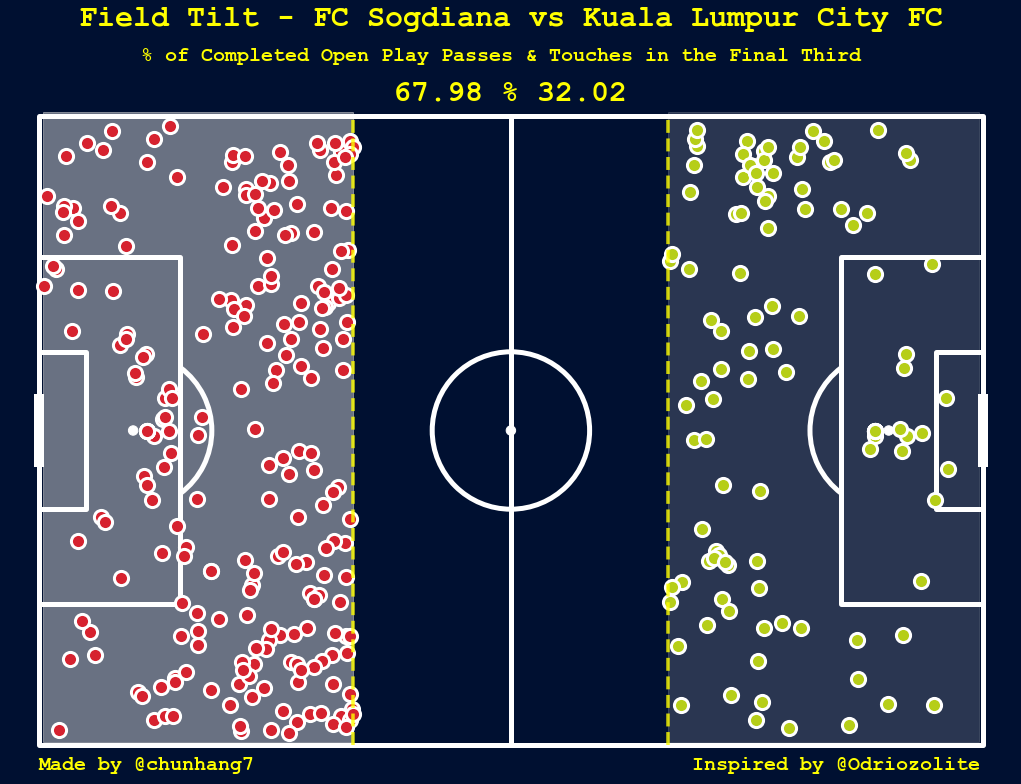

In [28]:
#Set color
homecolor = '#d6222f'
awaycolor = '#b6ce18'

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#001031', line_color='white',linewidth=5, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#001031')

#inverse y-axis
plt.gca().invert_yaxis()

#plot the pass locations for home side
plt.scatter(dfhome.x, dfhome.y, marker='o', s=200, c=homecolor, 
            linewidth = 3, edgecolor='w')

#plot the pass locations for away side
plt.scatter(dfaway.x, dfaway.y, marker='o', s=200, c=awaycolor, 
          linewidth = 3, edgecolor='w')

#Draw line
ax.plot([80,80], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.8)

ax.plot([40,40], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.8)

#shade
plt.axvspan(80,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.2)

plt.axvspan(0.5,40,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.5)

#Annotations
plt.title("Field Tilt - " + home +" vs " + away+"\n",color='yellow',size=30, 
          fontfamily = "Courier New", fontweight = "bold",pad=30)

ax.text(13,87, '% of Completed Open Play Passes & Touches in the Final Third', fontsize=20, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(45,82, h_tilt_p + ' % ' + a_tilt_p, fontsize=30, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(-0.1, -2.5, 'Made by @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(83, -2.5, 'Inspired by @Odriozolite', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

In [30]:
a_dt = [0]
h_dt= [0]
a_min = [0]
h_min = [0]
a_tilt = [0]
h_tilt= [0]
home_goals_list = [0]
away_goals_list = [0]
minute=[0]
goalmin_h=[]
goalmin_a=[]

strt_min= df['timeMin'].min()
end_min=df['timeMin'].max()

In [31]:
#New dataframes for the goals, deep touches and minutes 
#goal_h = dfhomem[(dfhomem['type/displayName'] == 'Goal')].sum()

for x in range(strt_min,end_min):
    #For every minute, calculate final third touches and append to a list
    dfhomem= dfhome[dfhome['timeMin']==x]
    deeptouch_h = dfhomem['f3rd_touch'].sum()
    h_dt.append(deeptouch_h)
    
    #For every minute, calculate goals and append to a list
    goal_h = dfhomem['Goal'].sum()
    h_min.append(x)

    #For every minute, calculate final third touches and append to a list
    dfawaym= dfaway[dfaway['timeMin']==x]    
    deeptouch_a = dfawaym['f3rd_touch'].sum()
    a_dt.append(deeptouch_a)

    #For every minute, calculate goals and append to a list
    goal_a = dfawaym['Goal'].sum()
    a_min.append(x)
    
    away_goals_list.append(goal_a)
    home_goals_list.append(goal_h)
    
    if goal_a > 0:
        goalmin_a.append(x)
    elif goal_h > 0:
        goalmin_h.append(x)

In [32]:
# Everything in a df and calculate the rolling average
df_hg = pd.DataFrame({'Goal':goalmin_h,"Value": 0})
df_ag = pd.DataFrame({'Goal':goalmin_a,"Value": 0})
df_dt = pd.DataFrame({'Minute':a_min,"Home Deep Touch": h_dt, 'Away Deep Touch': a_dt})

window1 = 10

df_dt['dt_h_MA'] = df_dt['Home Deep Touch'].rolling(window=window1).mean()
df_dt['dt_a_MA'] = df_dt['Away Deep Touch'].rolling(window=window1).mean()

df_dt['Tilt']=(df_dt['dt_h_MA']/(df_dt['dt_h_MA']+df_dt['dt_a_MA']))-0.5
df_dt['Tilt1']=gaussian_filter(df_dt['Tilt'],1)
window1=str(window1)

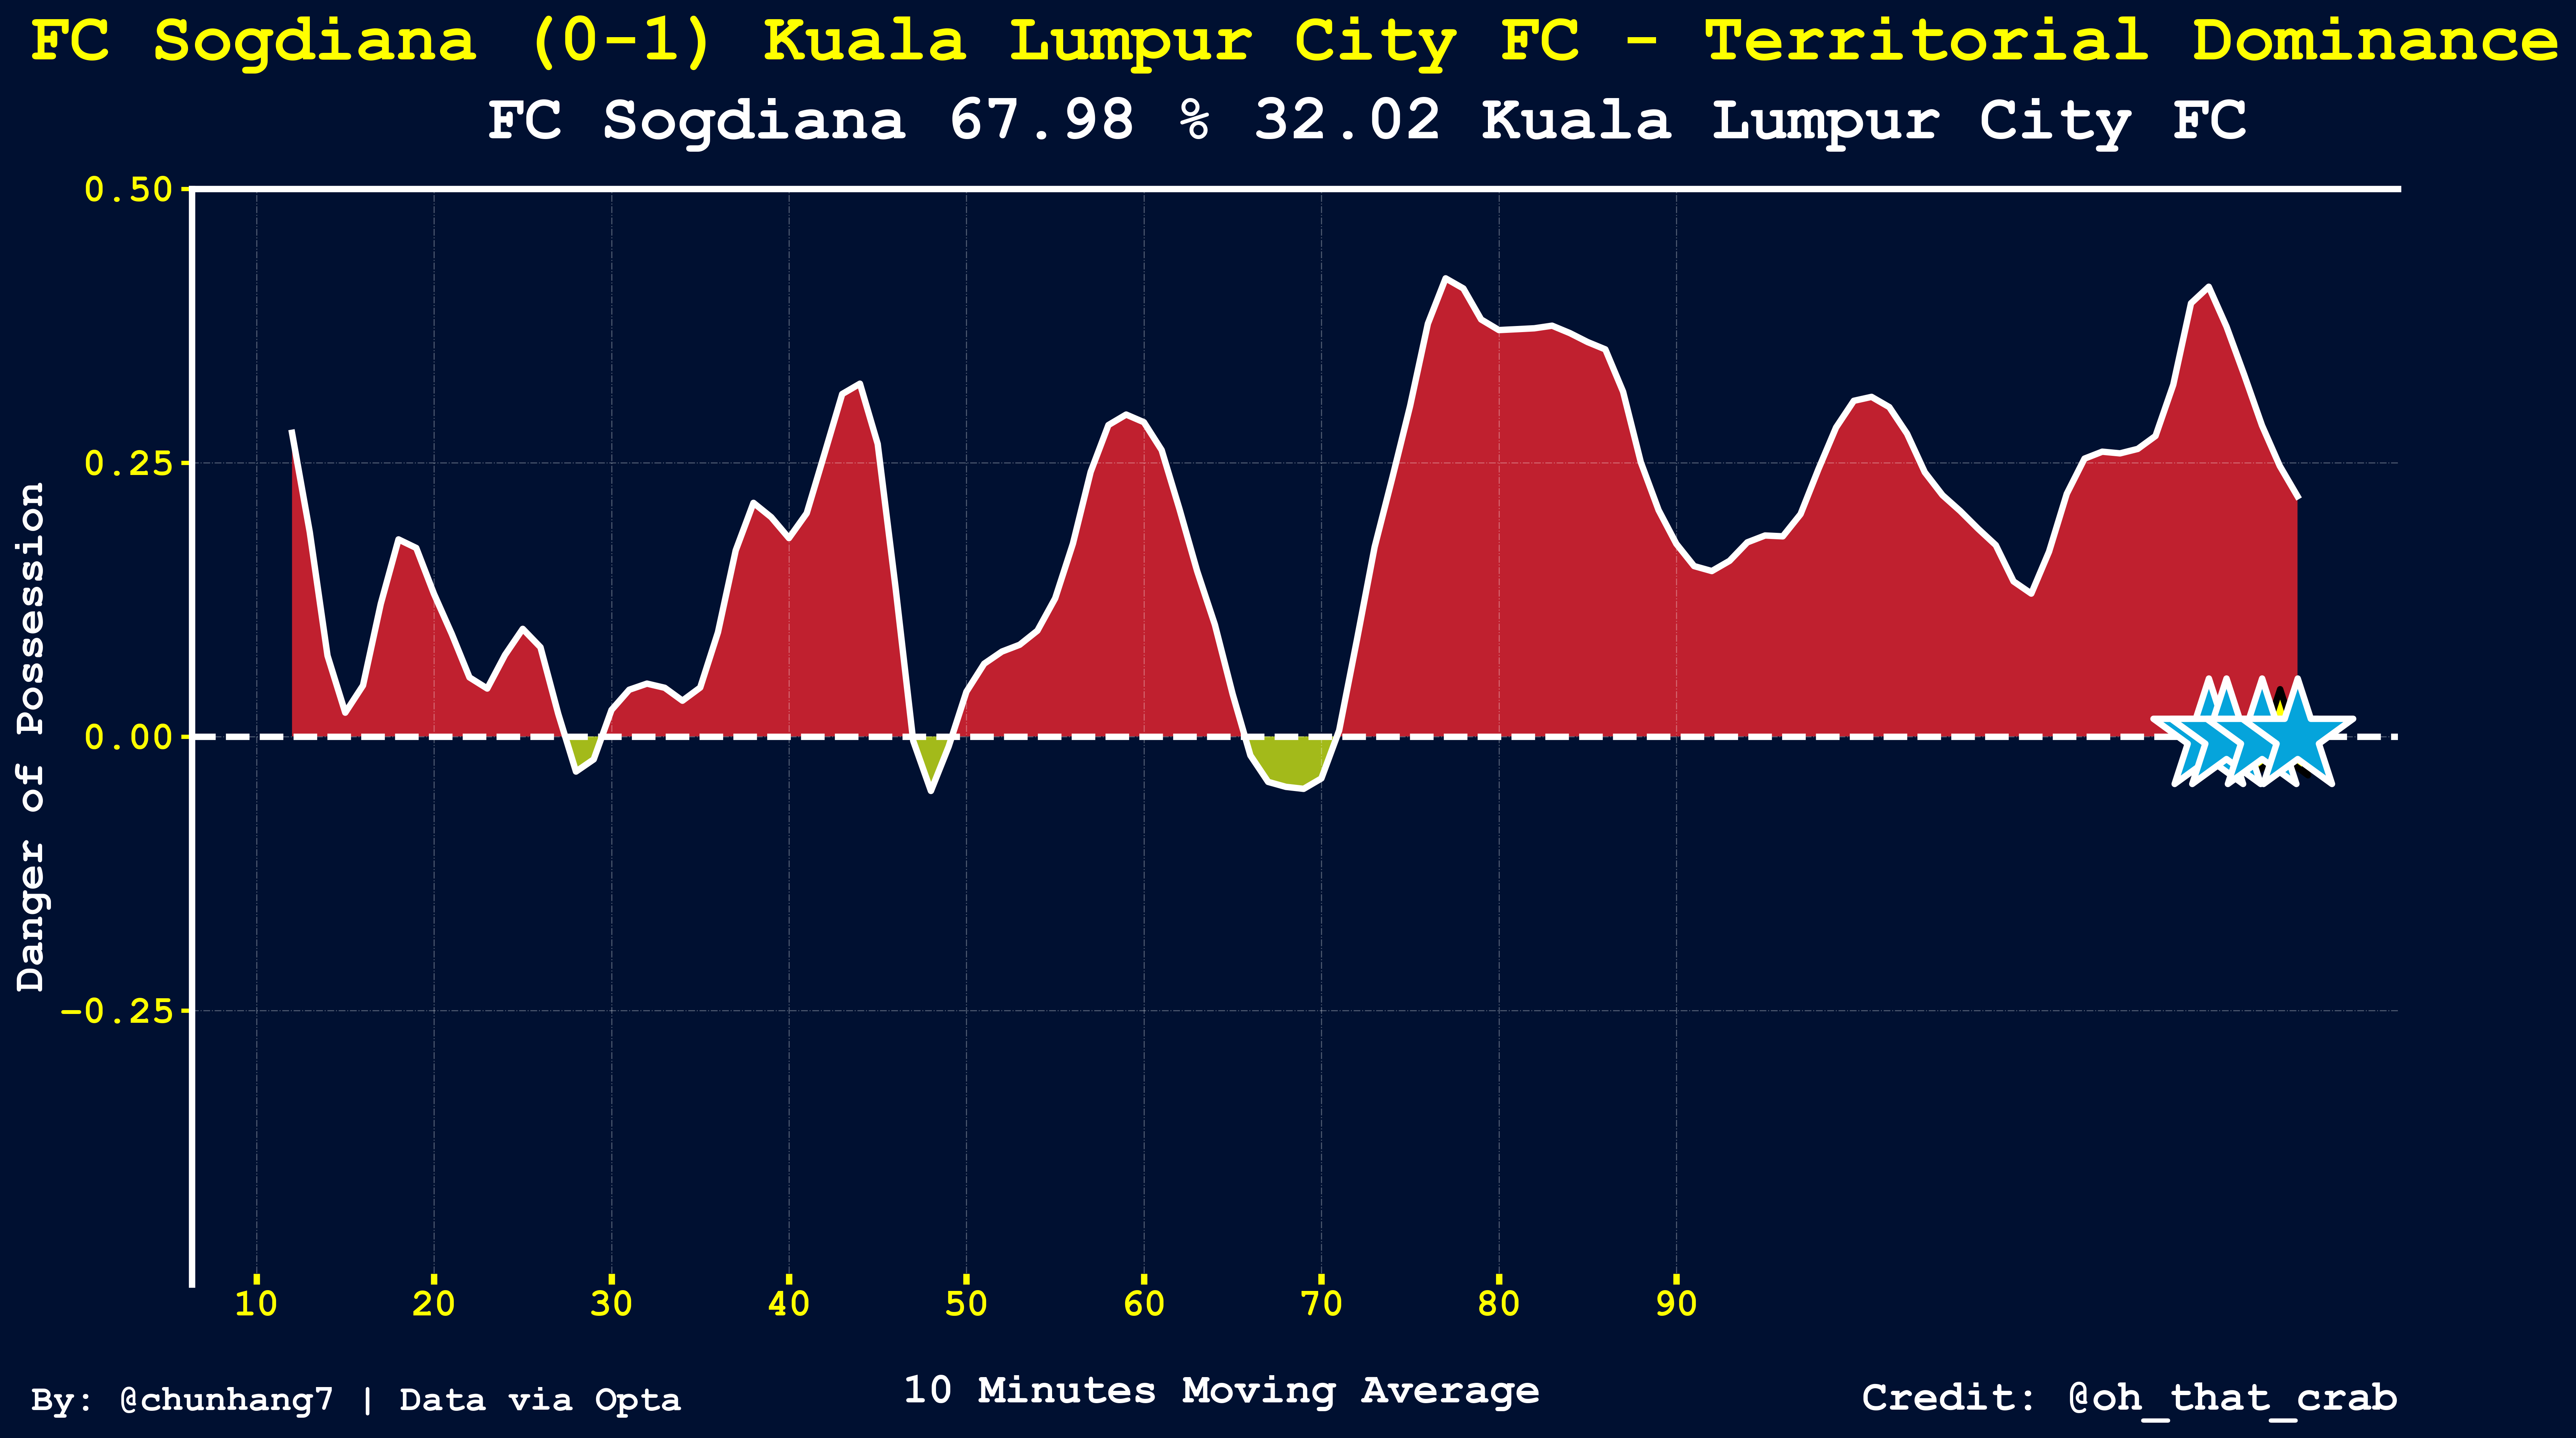

In [34]:
#make the plot
fig, ax = plt.subplots(figsize=(16,11))
fig.set_facecolor('#001031')
mpl.rcParams['figure.dpi'] = 400

#background color
ax.patch.set_facecolor('#001031')

#set up our base layer
mpl.rcParams['xtick.color'] = 'yellow'
mpl.rcParams['ytick.color'] = 'yellow'

#setting up the grid
ax.grid(ls='-.', lw=.5, color='white', axis='y', zorder=0, alpha=0.3)
ax.grid(ls='-.', lw=.5, color='white', axis='x', zorder=0, alpha=0.3)

#Setting up the spine
spines = ['bottom','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
#Set spine width & color
ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')

#set the ticks
ax.set_xticks([0,10,20,30,40,50,60,70,80,90])
ax.set_yticks([-0.25,0,0.25,0.5,0.75,1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=3, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=3, width=2,length=5)

ax.set_ylabel('Danger of Possession',fontname='Courier New',color='white',fontsize=20, fontweight = 'bold')

#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 18}
mpl.rc('font', **font)

#Filling
#home
ax.fill_between(df_dt.Minute, df_dt.Tilt1, 0, where=df_dt.Tilt1[0:] >=0, facecolor=homecolor, interpolate=True, alpha=0.9)

#away
ax.fill_between(df_dt.Minute, df_dt.Tilt1, 0, where=df_dt.Tilt1[0:] <=0, facecolor=awaycolor, interpolate=True, alpha=0.9)

ax.axhline(0, color='white', ls='--',lw=3)

#plot the goals
#home
ax.scatter(x=df_hg['Goal'],y=df_hg['Value'],marker='*',s=2000, color='yellow', zorder=3, 
            edgecolors='black',linewidths=3)
#away
ax.scatter(x=df_ag['Goal'],y=df_ag['Value'],marker='*',s=3000, color='#05a4db', zorder=3, 
            edgecolors='w',linewidths=3)

#outline color
ax.plot(df_dt.Minute,df_dt.Tilt1,color='white',lw=3)

#Set limit
ax.set_ylim([-0.5, 0.5])
plt.subplots_adjust(left=0.05,
                    bottom=0.15, 
                    right=0.95, 
                    top=0.8, 
                    wspace=0, 
                    hspace=0.5)

#set title
highlight_text = [{'color': 'w'},
                  {'color': 'w'}]

plt.title(home +" (0-1) "+ away +" - Territorial Dominance\n",color='yellow',size=32, 
          fontfamily = "Courier New", fontweight = "bold",pad=30)

#Annotations
fig.text(x=0.17, y=0.83,
         s=f"{home} {h_tilt_p} % {a_tilt_p} {away}", fontsize=30, 
         color='white', fontweight = 'bold', fontfamily = 'Courier New')


fig.text(0.95, 0.08,'Credit: @oh_that_crab', fontsize=20, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

fig.text(0.25, 0.08, 'By: @chunhang7 | Data via Opta', fontsize=17, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

fig.text(0.34, 0.08, window1 + ' Minutes Moving Average',
         fontsize=20, color='white', fontweight = 'bold', fontfamily = 'Courier New')

plt.show()